# Advanced quantitative techniques - Class 5 - Comparing texts

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Document-Term-Matrix

In [95]:
# create dictionary with keys being file name and values being the content of the speech

files = ['Trump.Inaug.2017', 'Obama.Inaug.2009']
paper_words = {}

for d in files: 
    file_path = 'Data/' + str(d) + '.txt'
    with open(file_path, 'rb') as f:
        f = [f.read().decode('utf8', 'ignore').replace('\r\n', " ").replace('\ufeff', '')]
        paper_words[d] = f

The `shorttext` package provides a preprocessing tool that performs the following text preprocessing all in one go: 
- remove special characters
- remove numerals
- convert all alphabets to lower cases
- remove stopwords
- stem the words using Porter stemmer

This package relies on the spaCy package among others. Although spaCy should be automatically installed when you install `shorttext`, you may have to download spaCy's 'en' data separately. This can be done in terminal using the command `python -m spacy download en`

In [96]:
from shorttext.utils import standard_text_preprocessor_1
preprocessor1 = standard_text_preprocessor_1()

# get corpus into the right format to be preprocessed
docids = sorted(paper_words.keys())
addresses = [a for docid in docids for a in paper_words[docid]]

# apply preprocessing
corpus = [preprocessor1(a).split(' ') for a in addresses]

# remove empty characters
corpus = [[w for w in d if w != ''] for d in corpus]

We can also use `shorttext` to create the document term matrix. 

In [72]:
from shorttext.utils import DocumentTermMatrix

dtm = DocumentTermMatrix(corpus)
dtm_df = dtm.generate_dtm_dataframe()
dtm_df.index = docids

In [136]:
dtm_df.T.head(10)

,Obama.Inaug.2009,Trump.Inaug.2017
abroad,1.0,0.0
absolut,1.0,0.0
act,5.0,0.0
action,1.0,2.0
advanc,2.0,0.0
affirm,1.0,0.0
afford,1.0,0.0
africa,1.0,0.0
ago,1.0,0.0
agre,1.0,0.0


## Wordclouds

(-0.5, 399.5, 199.5, -0.5)

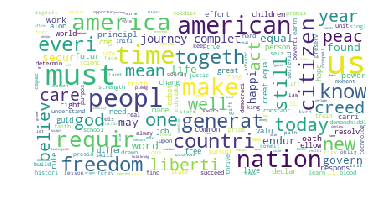

In [161]:
# slide 11
from wordcloud import WordCloud
Obama = ' '.join(corpus[0])
wordcloud = WordCloud(background_color="white", max_font_size=40).generate(Obama)
plt.imshow(wordcloud)
plt.axis("off")  

(-0.5, 399.5, 199.5, -0.5)

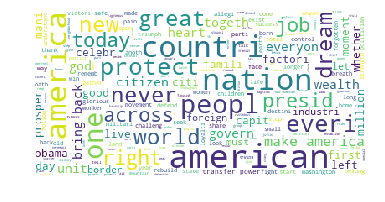

In [159]:
Trump = ' '.join(corpus[1])
wordcloud = WordCloud(background_color="white", max_font_size=40).generate(Trump)
plt.imshow(wordcloud)
plt.axis("off")  

## Most distinctive words for each speaker

In [73]:
dtm_T = dtm_df.T

# Allow words to be a column instead of the index
dtm_T.reset_index(drop=False, inplace=True)
dtm_T.rename(columns={'index': 'words'}, inplace=True)

In [74]:
dtm_T['Obama_prop'] = dtm_T['Obama.Inaug.2009'].apply(lambda x: x/dtm_T['Obama.Inaug.2009'].sum())
dtm_T['Trump_prop'] = dtm_T['Trump.Inaug.2017'].apply(lambda x: x/dtm_T['Trump.Inaug.2017'].sum())

dtm_T['Obama_over_Trump'] = dtm_T.Obama_prop - dtm_T.Trump_prop

#### Most Obama-esque words

In [75]:
# slide 14
dtm_T.sort_values('Obama_over_Trump', ascending=False, inplace=True)
dtm_T.head(10)

,words,Obama.Inaug.2009,Trump.Inaug.2017,Obama_prop,Trump_prop,Obama_over_Trump
577,us,21.0,2.0,0.020792,0.002865,0.017927
348,must,16.0,3.0,0.015842,0.004298,0.011544
546,time,11.0,2.0,0.010891,0.002865,0.008026
440,requir,8.0,0.0,0.007921,0.000000,0.007921
226,generat,7.0,0.0,0.006931,0.000000,0.006931
289,know,7.0,0.0,0.006931,0.000000,0.006931
179,equal,7.0,0.0,0.006931,0.000000,0.006931
507,still,6.0,0.0,0.005941,0.000000,0.005941
283,journey,6.0,0.0,0.005941,0.000000,0.005941
220,freedom,7.0,1.0,0.006931,0.001433,0.005498


#### Most Trumpian words

In [209]:
# slide 15
dtm_T.sort_values('Obama_over_Trump', inplace=True)
dtm_T.head(10)

,words,Obama.Inaug.2009,Trump.Inaug.2017,Obama_prop,Trump_prop,Obama_over_Trump
15,america,9.0,18.0,0.008911,0.025788,-0.016877
16,american,10.0,16.0,0.009901,0.022923,-0.013022
112,countri,7.0,12.0,0.006931,0.017192,-0.010261
351,nation,9.0,13.0,0.008911,0.018625,-0.009714
410,protect,1.0,7.0,0.000990,0.010029,-0.009039
622,back,0.0,6.0,0.000000,0.008596,-0.008596
152,dream,1.0,6.0,0.000990,0.008596,-0.007606
611,across,0.0,5.0,0.000000,0.007163,-0.007163
363,one,6.0,9.0,0.005941,0.012894,-0.006953
355,never,2.0,6.0,0.001980,0.008596,-0.006616


In [76]:
dtm_T.reset_index(drop=True, inplace=True)

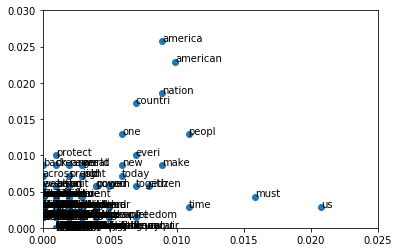

In [224]:
fig, ax = plt.subplots()
plt.scatter(dtm_T.Obama_prop, dtm_T.Trump_prop)
plt.xlim(0, 0.025)
plt.ylim(0, 0.03)

for i, txt in enumerate(dtm_T.words):
    ax.annotate(txt, (dtm_T.Obama_prop[i], dtm_T.Trump_prop[i]))

## Similarities

Results below are a little different from results obtained in R, possibly because the Python method identified 851 words whereas the R method identified 796. 

In [77]:
# slide 34
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(dtm_df)

array([[1.        , 0.52002326],
       [0.52002326, 1.        ]])

In [245]:
dtm_df.T.corr(method='pearson')

,Obama.Inaug.2009,Trump.Inaug.2017
Obama.Inaug.2009,1.000000,0.334503
Trump.Inaug.2017,0.334503,1.000000


In [246]:
dtm_df.T.corr(method='spearman')

,Obama.Inaug.2009,Trump.Inaug.2017
Obama.Inaug.2009,1.000000,-0.320442
Trump.Inaug.2017,-0.320442,1.000000


In [254]:
from scipy.stats import chi2_contingency

chi2_contingency(dtm_df)

(985.9172561072357,
 0.0008121694135871572,
 850,
 array([[0.59133489, 0.59133489, 2.95667447, ..., 0.59133489, 0.59133489,
         0.59133489],
        [0.40866511, 0.40866511, 2.04332553, ..., 0.40866511, 0.40866511,
         0.40866511]]))

### Regression models

In [267]:
# Rename columns to avoid errors in regression model specification
dtm_T2 = dtm_T.rename(columns={'Trump.Inaug.2017': 'Trump17', 'Obama.Inaug.2009': 'Obama09'})

In [268]:
from statsmodels.regression.linear_model import OLS

m1a = OLS.from_formula('Trump17 ~ Obama09', data=dtm_T2).fit()
m1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Trump17   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     107.0
Date:                Sun, 19 Aug 2018   Prob (F-statistic):           1.08e-23
Time:                        00:53:37   Log-Likelihood:                -1497.8
No. Observations:                 851   AIC:                             3000.
Df Residuals:                     849   BIC:                             3009.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4583      0.060      7.688      0.000       0.341       0.575
Obama09        0.3049      0.029     10.342      0.000       0.247       0.363
==============================================================================
Omnibus:                      737.303   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28689.931
Skew:                           3.736   Prob(JB):                         0.00
Kurtosis:                      30.446   Cond. No.                         2.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [269]:
m1b = OLS.from_formula('Trump17 ~ Obama09 + I(Obama09**2)', data=dtm_T2).fit()
m1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Trump17   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     55.56
Date:                Sun, 19 Aug 2018   Prob (F-statistic):           2.11e-23
Time:                        00:54:35   Log-Likelihood:                -1495.9
No. Observations:                 851   AIC:                             2998.
Df Residuals:                     848   BIC:                             3012.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5286      0.070      7.599      0.000       0.392       0.665
Obama09             0.2164      0.054      4.003      0.000       0.110       0.323
I(Obama09 ** 2)     0.0085      0.004      1.951      0.051   -5.17e-05       0.017
==============================================================================
Omnibus:                      739.661   Durbin-Watson:                   0.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30816.034
Skew:                           3.726   Prob(JB):                         0.00
Kurtosis:                      31.523   Cond. No.                         35.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
m2a = OLS.from_formula('Trump_prop ~ Obama_prop', data=dtm_T).fit()
m2a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Trump_prop   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     107.0
Date:                Sun, 19 Aug 2018   Prob (F-statistic):           1.08e-23
Time:                        00:57:30   Log-Likelihood:                 4074.8
No. Observations:                 851   AIC:                            -8146.
Df Residuals:                     849   BIC:                            -8136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007   8.54e-05      7.688      0.000       0.000       0.001
Obama_prop     0.4412      0.043     10.342      0.000       0.357       0.525
==============================================================================
Omnibus:                      737.303   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28689.931
Skew:                           3.736   Prob(JB):                         0.00
Kurtosis:                      30.446   Cond. No.                         617.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [271]:
m2b = OLS.from_formula('Trump_prop ~ Obama_prop + I(Obama_prop**2)', data=dtm_T).fit()
m2b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Trump_prop   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     55.56
Date:                Sun, 19 Aug 2018   Prob (F-statistic):           2.11e-23
Time:                        00:58:15   Log-Likelihood:                 4076.7
No. Observations:                 851   AIC:                            -8147.
Df Residuals:                     848   BIC:                            -8133.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0008   9.97e-05      7.599      0.000       0.001       0.001
Obama_prop             0.3132      0.078      4.003      0.000       0.160       0.467
I(Obama_prop ** 2)    12.4345      6.374      1.951      0.051      -0.075      24.945
==============================================================================
Omnibus:                      739.661   Durbin-Watson:                   0.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30816.034
Skew:                           3.726   Prob(JB):                         0.00
Kurtosis:                      31.523   Cond. No.                     9.23e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Term frequency, inverse document frequency (tfidf)

In [290]:
# slide 44

idf = np.log(dtm_df.shape[0]/dtm_df.sum(axis=0))

tfidf = dtm_df * idf

tfidf.T.head(10)

,Obama.Inaug.2009,Trump.Inaug.2017
abroad,0.693147,0.00000
absolut,0.693147,0.00000
act,-4.581454,-0.00000
action,-0.405465,-0.81093
advanc,0.000000,0.00000
affirm,0.693147,0.00000
afford,0.693147,0.00000
africa,0.693147,0.00000
ago,0.693147,0.00000
agre,0.693147,0.00000


In [291]:
tfidf.T.corr(method='pearson')

,Obama.Inaug.2009,Trump.Inaug.2017
Obama.Inaug.2009,1.000000,0.661791
Trump.Inaug.2017,0.661791,1.000000


## Another example - comparing three graduate programs

Note that the program descriptions have been updated since the time when Greg obtained his examples, so some of the results might be different from what appears on the lecture slides.

In [3]:
files = ['QMSS', 'A3SR', 'AQR']
docs = {}

for d in files: 
    file_path = 'Data/' + str(d) + '.txt'
    with open(file_path, 'rb') as f:
        f = [f.read().decode('utf8', 'ignore').replace('\n', " ")]
        docs[d] = f

In [4]:
docs

{'QMSS': ["Quantitative Methods in the Social Sciences (QMSS) is a free-standing Master's or Arts program within the Graduate School of Arts and Sciences at Columbia University, associated with the Institute for Social and Economic Research and Policy. It is an innovative, flexible, interdisciplinary social science degree that focuses on quantitative research techniques and strategies. The program integrates the perspectives and research methods of eight social science disciplines: Economics, History, Political Science, Psychology, Sociology, Computer Science, and Statistics.  QMSS provides students with rigorous training in quantitative research, with an emphasis on written and oral communication about research techniques and findings. These skills prepare QMSS graduates to enter (or further) an analytical or research career or to continue their education in a PhD program.  Having drawn students in varied fields from more than 30 countries, QMSS students bring a unique range of experi

In [9]:
#import string

from nltk.corpus import stopwords
stop = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

processed_docs = {}
for program, text in docs.items():
    # convert list to string
    text = ' '.join(text)
    
    # to lower case
    text = text.lower()
    
    # remove punctuations
    ## specifying the punctations to remove because we want to keep hyphenated words
    text = "".join(c for c in text.strip() if c not in ('!','.',':', ',', '(', ')', "'"))
    
    # this would be the method to use if you want to remove all punctuations:
    # translator = str.maketrans('', '', string.punctuation)
    # text = text.translate(translator)
    
    # remove stopwords
    text = [word for word in text.split() if word not in stop]
    
    # remove specific words
    remove_words = ['department', 'email']
    text = [word for word in text if word not in remove_words]
    text = ' '.join(text)
    
    # substitute words
    text = text.replace('qualitative research', 'QDA')
    text = text.replace('qualitative studies', 'QDA')
    text = text.replace('qualitative analysis', 'QDA')
    text = text.replace('research methods', 'research_methods')
    
    # stem document
    stemmed_text = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(stemmed_text)
    
    processed_docs[program] = text

In [10]:
docids = sorted(processed_docs.keys())

corpus = [[word for word in processed_docs[docid].split()] for docid in docids]

In [11]:
dtm = DocumentTermMatrix(corpus)
dtm_df = dtm.generate_dtm_dataframe()
dtm_df.index = docids

In [12]:
dtm_df

,academ,accord,acquir,address,adn,advanc,allow,american,analysi,analyt,...,research_method,return,school,sever,sociolog,undergradu,uniqu,vari,within,written
A3SR,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AQR,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QMSS,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Frequent terms

In [13]:
# frequent terms in corpus
[c for c in dtm_df.columns if dtm_df[c].sum()>=10]

['program', 'research', 'scienc', 'social', 'statist', 'student']

In [14]:
# frequent terms in A3SR
[c for c in dtm_df.columns if dtm_df.loc['A3SR', c].sum()>=5]

['data', 'program', 'research', 'scienc', 'statist', 'student']

In [15]:
# frequent terms in AQR
[c for c in dtm_df.columns if dtm_df.loc['AQR', c].sum()>=5]

['program']

In [16]:
# frequent terms in QMSS
[c for c in dtm_df.columns if dtm_df.loc['QMSS', c].sum()>=5]

['program', 'research', 'scienc', 'student', 'qmss']

In [17]:
# slide 60
dtm_df.T.head()

,A3SR,AQR,QMSS
academ,1.0,1.0,1.0
accord,1.0,0.0,0.0
acquir,1.0,1.0,1.0
address,1.0,0.0,0.0
adn,1.0,0.0,0.0


## Measures of similarity

In [440]:
# slide 61
dtm_df.T.corr(method='pearson')

,A3SR,AQR,QMSS
A3SR,1.000000,0.453771,0.478894
AQR,0.453771,1.000000,0.481453
QMSS,0.478894,0.481453,1.000000


In [442]:
cosine_similarity(dtm_df)

array([[1.        , 0.60484469, 0.6210183 ],
       [0.60484469, 1.        , 0.60259728],
       [0.6210183 , 0.60259728, 1.        ]])

In [447]:
chi2_contingency(dtm_df.T)[:3]

(449.19538049705903, 0.5284153484650135, 452)

## Making the matrix more dense 

In [461]:
# get words that appear more than once in the corpus
dtm_df.loc[:, dtm_df.sum(axis=0)>1]

,academ,acquir,advanc,allow,analysi,analyt,appli,associ,behavior,build,...,innov,master,state,strategi,tool,univers,art,directli,incom,qmss
A3SR,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AQR,1.0,1.0,1.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0
QMSS,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,2.0,5.0


## Weighting the matrix by tf-idf

In [18]:
idf = np.log(dtm_df.shape[0]/dtm_df.sum(axis=0))
tfidf = dtm_df * idf
tfidf

,academ,accord,acquir,address,adn,advanc,allow,american,analysi,analyt,...,research_method,return,school,sever,sociolog,undergradu,uniqu,vari,within,written
A3SR,0.0,1.098612,0.0,1.098612,1.098612,0.405465,0.405465,1.098612,0.0,0.405465,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AQR,0.0,0.000000,0.0,0.000000,0.000000,0.405465,0.405465,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QMSS,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.405465,...,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612


In [31]:
# top 10 terms per document by tf-idf
tfidf.T.sort_values('A3SR', ascending=False)['A3SR'][:10].index

Index(['societi', 'key', 'partnership', 'particular', 'offer', 'nearli',
       'nation', 'methodolog', 'meet', 'media'],
      dtype='object')

In [30]:
tfidf.T.sort_values('AQR', ascending=False)['AQR'][:10].index

Index(['togeth', 'cutting-edg', 'employ', 'percentag', 'evalu', 'feder',
       'financ', 'govern', 'group', 'improv'],
      dtype='object')

In [29]:
tfidf.T.sort_values('QMSS', ascending=False)['QMSS'][:10].index

Index(['written', 'emphasi', 'institut', 'histori', 'hand', 'half', 'full-tim',
       'free-stand', 'focus', 'expertis'],
      dtype='object')

## Relative frequencies

In [32]:
dtm_df.head()

,academ,accord,acquir,address,adn,advanc,allow,american,analysi,analyt,...,research_method,return,school,sever,sociolog,undergradu,uniqu,vari,within,written
A3SR,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AQR,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QMSS,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [33]:
dtm_T_freq = dtm_df.T
dtm_T_freq['A3SR'] = dtm_T_freq['A3SR'].apply(lambda x: x/dtm_T_freq['A3SR'].sum())
dtm_T_freq['AQR'] = dtm_T_freq['AQR'].apply(lambda x: x/dtm_T_freq['AQR'].sum())
dtm_T_freq['QMSS'] = dtm_T_freq['QMSS'].apply(lambda x: x/dtm_T_freq['QMSS'].sum())

dtm_T_freq.head()

,A3SR,AQR,QMSS
academ,0.004831,0.008475,0.007407
accord,0.004831,0.000000,0.000000
acquir,0.004831,0.008475,0.007407
address,0.004831,0.000000,0.000000
adn,0.004831,0.000000,0.000000


#### Words most like QMSS and least like A3SR

In [35]:
dtm_T_freq['ratio'] = dtm_T_freq.QMSS - dtm_T_freq.A3SR
sort_QMSS = dtm_T_freq.sort_values('ratio', ascending=False)
sort_QMSS.head(15)

,A3SR,AQR,QMSS,ratio
qmss,0.000000,0.000000,0.037037,0.037037
student,0.038647,0.033898,0.059259,0.020612
quantit,0.004831,0.033898,0.022222,0.017391
year,0.004831,0.000000,0.022222,0.017391
incom,0.000000,0.000000,0.014815,0.014815
directli,0.000000,0.000000,0.014815,0.014815
art,0.000000,0.000000,0.014815,0.014815
program,0.038647,0.067797,0.051852,0.013205
research,0.024155,0.033898,0.037037,0.012882
scienc,0.033816,0.016949,0.044444,0.010628


#### Words most like A3SR and least like QMSS

In [37]:
sort_A3SR = dtm_T_freq.sort_values('ratio')
sort_A3SR.head(15)

,A3SR,AQR,QMSS,ratio
statist,0.038647,0.016949,0.007407,-0.031240
data,0.028986,0.008475,0.000000,-0.028986
behavior,0.014493,0.000000,0.000000,-0.014493
health,0.014493,0.000000,0.000000,-0.014493
studi,0.019324,0.008475,0.007407,-0.011916
well-posit,0.009662,0.000000,0.000000,-0.009662
doctor,0.009662,0.008475,0.000000,-0.009662
one,0.009662,0.000000,0.000000,-0.009662
wide,0.009662,0.000000,0.000000,-0.009662
challeng,0.009662,0.000000,0.000000,-0.009662


## Using clustering to determine authorship

In [99]:
import os
files = os.listdir('Data/sous/')

files.remove('.DS_Store')

In [100]:
sous = {}

for d in files: 
    file_path = 'Data/sous/' + str(d)
    with open(file_path, 'rb') as f:
        f = [f.read().decode('utf8', 'ignore').replace('\n', " ").replace('\r', '')]
        sous[d] = f

In [106]:
docids = sorted(sous.keys())
addresses = [a for docid in docids for a in sous[docid]]

from shorttext.utils import standard_text_preprocessor_1
preprocessor1 = standard_text_preprocessor_1()

# apply preprocessing
corpus = [preprocessor1(a).split(' ') for a in addresses]

corpus = [[w for w in d if w != ''] for d in corpus]

In [108]:
dtm = DocumentTermMatrix(corpus)
dtm_df = dtm.generate_dtm_dataframe()
dtm_df.index = docids

In [109]:
dist = 1 - cosine_similarity(dtm_df)

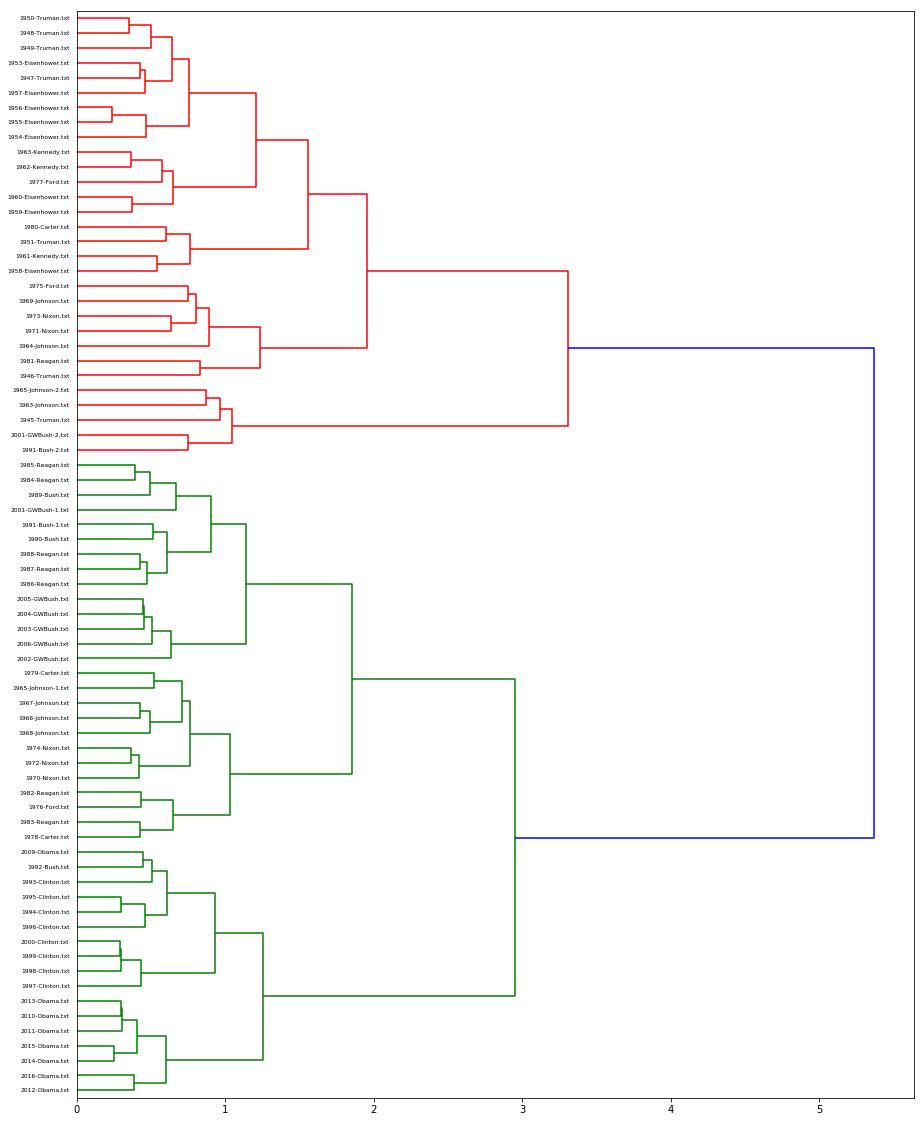

In [110]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=docids)